In [1]:
# setup 
import pandas as pd
import matplotlib.pyplot as plt

# Initital analysis of the business problem
## Taking into account the actual orders supposed to multiple records per
## Adding onto the dataframe to be able to group by and analyse them
- If amount, country and card are the same AND between timestamp is <= 1 minute then it's the same order 

In [2]:
# retrieve intermediate data
df = pd.read_csv('../data/intermediate/clean_data.csv', index_col=False)
df.head()

,tmsp,country,amount,success,psp,3d_secured,card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [3]:
# Sort data by timestamp, looks sorted already, just to make sure
df['tmsp'] = pd.to_datetime(df['tmsp'])
df = df.sort_values(by='tmsp')

# Create a function to identify the same transaction
# aggregate by within one minute of previous where country, card, amount is the same 
def identify_transactions(df):
    # Shift the relevant columns to compare with the next row
    df['time_diff'] = df['tmsp'].diff().fillna(pd.Timedelta(seconds=0)) # To be able to be within the 1 minute limit
    df['same_transaction'] = ((df['country'] == df['country'].shift()) &
                               (df['amount'] == df['amount'].shift()) &
                               (df['card'] == df['card'].shift()) &
                               (df['time_diff'] <= pd.Timedelta(minutes=1)))

    # Create a transaction group identifier by cumulative sum
    df['order_id'] = (~df['same_transaction']).cumsum()

    return df

In [4]:
# Apply the function
df_transaction = identify_transactions(df)

# Show the result
display(df_transaction)

,tmsp,country,amount,success,psp,3d_secured,card,time_diff,same_transaction,order_id
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0 days 00:00:00,False,1
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0 days 00:00:06,True,1
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0 days 00:01:32,False,2
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0 days 00:00:24,True,2
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0 days 00:01:20,False,3
...,...,...,...,...,...,...,...,...,...,...
50405,2019-02-28 23:45:39,Switzerland,415,0,UK_Card,0,Visa,0 days 00:00:00,True,27337
50406,2019-02-28 23:46:48,Austria,91,0,UK_Card,0,Master,0 days 00:01:09,False,27338
50407,2019-02-28 23:47:04,Austria,91,0,UK_Card,0,Master,0 days 00:00:16,True,27338
50408,2019-02-28 23:47:36,Austria,91,0,UK_Card,0,Master,0 days 00:00:32,True,27338


- there are 27338 order_id's

In [5]:
# total_orders
total_orders = df['order_id'].nunique()

# Group by order_id and calculate the max success for each order
order_success = df.groupby('order_id')['success'].max()

# total_failed_orders
failed_orders = order_success[order_success == 0].index
failed_orders_df = df[df['order_id'].isin(failed_orders)]
total_failed_orders = failed_orders_df['order_id'].nunique()

# total_success_orders_df
success_orders = order_success[order_success == 1].index
success_orders_df = df[df['order_id'].isin(success_orders)]
total_success_orders_df = success_orders_df['order_id'].nunique()

# failed_proportion
failed_proportion = total_failed_orders / total_orders
failed_proportion_percentage = failed_proportion * 100

# failed_orders_tries_before_giving_up
failed_orders_tries_before_giving_up = failed_orders_df.groupby('order_id').size() - 1

# calculate the min, max, and mean number of tries before giving up (excluding the final attempt)
min_tries_before_giving_up = failed_orders_tries_before_giving_up.min()
max_tries_before_giving_up = failed_orders_tries_before_giving_up.max()
mean_tries_before_giving_up = failed_orders_tries_before_giving_up.mean()

# successful_first_attempts
df['first_attempt'] = df.groupby('order_id')['tmsp'].transform('min') == df['tmsp']
successful_first_attempts = df[df['first_attempt']]['success'].sum()

# percentage_first_try_success
percentage_first_try_success = (successful_first_attempts / total_orders) * 100

print(f"Total number of orders: {total_orders}")
print(f"Total number of failed orders: {total_failed_orders}")
print(f"Total number of overall successful transactions: {total_success_orders_df}")
print(f"Proportion of failed orders: {failed_proportion:.4f} ({failed_proportion_percentage:.2f}%)")
print(f"Number of successful transactions on the first attempt: {successful_first_attempts}")
print(f"Minimum number of tries before giving up (excluding final try): {min_tries_before_giving_up}")
print(f"Maximum number of tries before giving up (excluding final try): {max_tries_before_giving_up}")
print(f"Mean number of tries before giving up (excluding final try): {mean_tries_before_giving_up:.2f}")
print(f"Percentage of transactions that work on the first try: {percentage_first_try_success:.2f}%")

Total number of orders: 27338
Total number of failed orders: 17113
Total number of overall successful transactions: 10225
Proportion of failed orders: 0.6260 (62.60%)
Number of successful transactions on the first attempt: 5681
Minimum number of tries before giving up (excluding final try): 0
Maximum number of tries before giving up (excluding final try): 8
Mean number of tries before giving up (excluding final try): 0.84
Percentage of transactions that work on the first try: 20.78%


- Overall it's not looking so good
    - only 20.63% of orders work on the first try
        - 4 out of 5 are experiencing issues with the payment
        - that means that approx half of the customers that manage to pay need more than one try
    - 62.6% of orders don't go through and abandon the cart 
        - high loss of revenue 
        - the transaction fees should not be the biggest concern here 
        - customers abandon the cart on average on the second try
        -- should not get to it -- we need a high chance of success

In [6]:
# clean up datafram 
display(df.columns)
df.drop(columns=['time_diff', 'first_attempt', 'same_transaction'], inplace=True)
display(df.columns)
display(df)

Index(['tmsp', 'country', 'amount', 'success', 'psp', '3d_secured', 'card',
       'time_diff', 'same_transaction', 'order_id', 'first_attempt'],
      dtype='object')

Index(['tmsp', 'country', 'amount', 'success', 'psp', '3d_secured', 'card',
       'order_id'],
      dtype='object')

,tmsp,country,amount,success,psp,3d_secured,card,order_id
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,1
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,1
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,2
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,2
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,3
...,...,...,...,...,...,...,...,...
50405,2019-02-28 23:45:39,Switzerland,415,0,UK_Card,0,Visa,27337
50406,2019-02-28 23:46:48,Austria,91,0,UK_Card,0,Master,27338
50407,2019-02-28 23:47:04,Austria,91,0,UK_Card,0,Master,27338
50408,2019-02-28 23:47:36,Austria,91,0,UK_Card,0,Master,27338


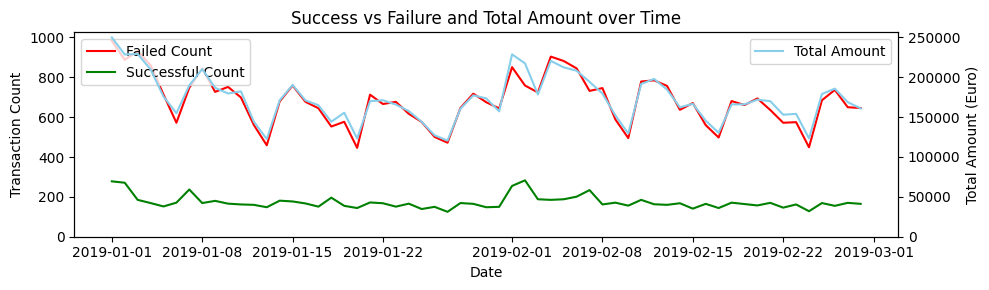

In [8]:
df['tmsp'] = pd.to_datetime(df['tmsp'])  \

# Group by timestamp and success/failure, then count
grouped = df.groupby([df['tmsp'].dt.date, 'success']).size().unstack(fill_value=0)
# Group by timestamp and success/failure, then sum the amount
amount_grouped = df.groupby([df['tmsp'].dt.date, 'success'])['amount'].sum().unstack(fill_value=0)

# Calculate the overall amount of orders (both successful and failed)
overall_amount_grouped = df.groupby(df['tmsp'].dt.date)['amount'].sum()

# Plot the data
fig, ax1 = plt.subplots(figsize=(10, 3))

# Plot count of failed and successful transactions
ax1.plot(grouped.index, grouped[0], label='Failed Count', color='red', linestyle='-')  # Failed (success = 0)
ax1.plot(grouped.index, grouped[1], label='Successful Count', color='green', linestyle='-')  # Successful (success = 1)

# Create a second y-axis to plot the total amount of all orders
ax2 = ax1.twinx()
ax2.plot(amount_grouped.index, amount_grouped[0] + amount_grouped[1], label='Total Amount', color='skyblue', linestyle='-')  # Total Amount (success + failed)

# Set y-axis limits to start at 0
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)

# Adding labels and legends
ax1.set_title('Success vs Failure and Total Amount over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Transaction Count')
ax2.set_ylabel('Total Amount (Euro)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

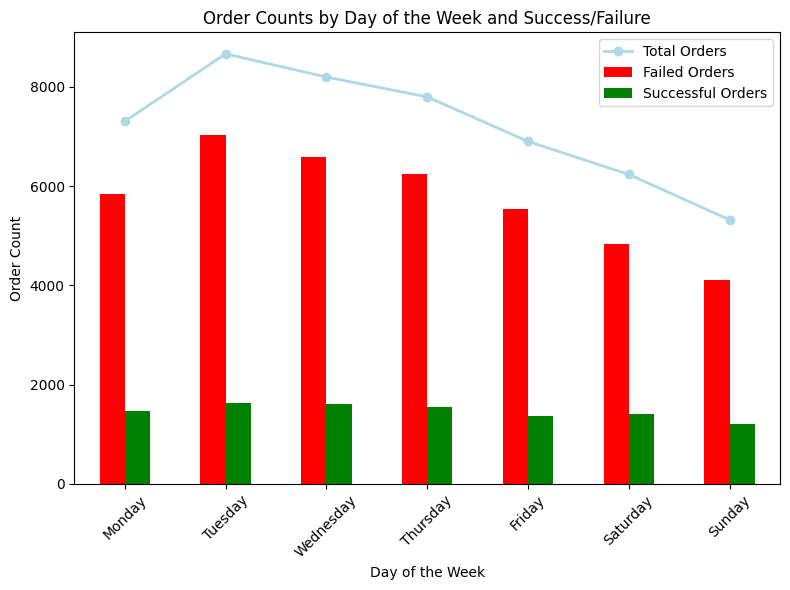

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is your dataframe and tmsp is the timestamp column
df['tmsp'] = pd.to_datetime(df['tmsp'])  # Ensure tmsp is in datetime format

# Extract the day of the week (0=Monday, 1=Tuesday, ..., 6=Sunday)
df['day_of_week'] = df['tmsp'].dt.dayofweek  # 0 is Monday, 6 is Sunday

# Group by day_of_week and success, then calculate the count of transactions
daily_grouped_count = df.groupby(['day_of_week', 'success']).size().unstack(fill_value=0)

# Map day_of_week to the corresponding day name for better readability
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_grouped_count.index = daily_grouped_count.index.map(lambda x: day_names[x])

# Calculate the total count per day (successful + failed)
total_counts = daily_grouped_count.sum(axis=1)

# Plot the data
fig, ax = plt.subplots(figsize=(8, 6))
daily_grouped_count.plot(kind='bar', stacked=False, ax=ax, color=['red', 'green'])

# Plot the total count line
ax.plot(daily_grouped_count.index, total_counts, label='Total Orders', color='lightblue', marker='o', linestyle='-', linewidth=2)

# Adding labels and legend
ax.set_title('Order Counts by Day of the Week and Success/Failure')
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Order Count')
ax.legend(['Total Orders', 'Failed Orders', 'Successful Orders'])

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
daily_grouped_count

success,0,1
day_of_week,,
Monday,5835,1469
Tuesday,7036,1627
Wednesday,6590,1605
Thursday,6241,1555
Friday,5529,1370
Saturday,4836,1398
Sunday,4115,1204


# Analyzing the costs and loss of revenue
## Adding the fees the dataframe to be able to analyse the costs 

In [11]:
# add psp fees 
fee_mapping = {
    ('Moneycard', 1): 5,   # Successful transaction with Moneycard
    ('Moneycard', 0): 2,   # Failed transaction with Moneycard
    ('Goldcard', 1): 10,   # Successful transaction with Goldcard
    ('Goldcard', 0): 5,    # Failed transaction with Goldcard
    ('UK_Card', 1): 3,     # Successful transaction with UK_Card
    ('UK_Card', 0): 1,     # Failed transaction with UK_Card
    ('Simplecard', 1): 1,  # Successful transaction with Simplecard
    ('Simplecard', 0): 0.5 # Failed transaction with Simplecard
}

In [12]:
# Create a new column 'fee' by applying the fee mapping based on 'psp' and 'success'
df['fee'] = df.apply(lambda row: fee_mapping.get((row['psp'], row['success']), 0), axis=1)

# Display the updated DataFrame with the 'fee' column
df.head()

,tmsp,country,amount,success,psp,3d_secured,card,order_id,day_of_week,fee
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,1,1,1.0
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,1,1,3.0
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,2,1,1.0
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,2,1,3.0
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,3,1,0.5


In [13]:
# Filter for transactions (where success == 0 and == 1)
failed_transactions_df = df[df['success'] == 0]
successful_transactions_df = df[df['success'] == 1]

# Sum the 'fee' column for these  transactions
total_failed_fees = failed_transactions_df['fee'].sum()
total_success_fees = successful_transactions_df['fee'].sum()

print(f"Total fees for failed transactions: {total_failed_fees} Euro")
print(f"Total fees for successful transactions: {total_success_fees} Euro")

Total fees for failed transactions: 49045.0 Euro
Total fees for successful transactions: 39499.0 Euro


In [14]:
# Calculate the total revenue by summing the amount for successful transactions
total_revenue = successful_transactions_df['amount'].sum()
failed_revenue = failed_transactions_df['amount'].sum()

print(f"Total revenue from successful transactions: {total_revenue} Euro")
print(f"Total revenue lost from failed transactions: {failed_revenue} Euro")

Total revenue from successful transactions: 1901430 Euro
Total revenue lost from failed transactions: 8301338 Euro


In [15]:
order_stats = df.groupby('order_id').agg(total_fee=('fee', 'sum'), success=('success', 'max'))
failed_orders = order_stats[order_stats['success'] == 0]['total_fee']
successful_orders = order_stats[order_stats['success'] == 1]['total_fee']
average_failed_fee_per_order = failed_orders.mean()
average_successful_fee_per_order = successful_orders.mean()

print(f"Average fees from successful transactions: {round(average_successful_fee_per_order, 2)} Euro")
print(f"Average fees from failed transactions: {round(average_failed_fee_per_order, 2)} Euro")

Average fees from successful transactions: 4.91 Euro
Average fees from failed transactions: 2.24 Euro


In [16]:
failed_orders.describe().T

count    17113.000000
mean         2.240753
std          1.995680
min          0.500000
25%          1.000000
50%          2.000000
75%          3.000000
max         21.500000
Name: total_fee, dtype: float64

In [17]:
successful_orders.describe().T

count    10225.000000
mean         4.909340
std          3.075233
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max         23.000000
Name: total_fee, dtype: float64

In [18]:
# Group by's to retrieve sum of amount and success boolean
order_amount = df.groupby('order_id')['amount'].sum()
order_success = df.groupby('order_id')['success'].max()

# Filter 
successful_orders = order_amount[order_success == 1]
failed_orders = order_amount[order_success == 0]

# Get averages 
average_amount_successful_orders = successful_orders.mean()
average_amount_failed_orders = failed_orders.mean()

print(f"Average amount per successful order: {average_amount_successful_orders:.2f} Euro")
print(f"Average amount per failed order: {average_amount_failed_orders:.2f} Euro")

Average amount per successful order: 341.96 Euro
Average amount per failed order: 391.88 Euro


In [19]:
successful_orders.describe().T

count    10225.000000
mean       341.959511
std        317.533677
min          6.000000
25%        150.000000
50%        246.000000
75%        411.000000
max       3492.000000
Name: amount, dtype: float64

In [20]:
failed_orders.describe().T

count    17113.000000
mean       391.879390
std        347.524978
min          6.000000
25%        180.000000
50%        280.000000
75%        496.000000
max       4149.000000
Name: amount, dtype: float64

- The total fees from failed transactions are higher than those from successful transactions, even though failed transactions have a lower mean fee (341.95 to 391.88)
- spread of amounts is quite large for both successful and failed orders, showing that there is significant variability in the amounts for both categories
    - number of failed transactions (17,113) is significantly higher than the number of successful transactions (10,225)
    - revenue possibly lost from failed transactions (€8,301,338) is over 4 times higher than the revenue earned from successful transactions (€1,901,430)
    - highlights the high potential cost of failed transactions to the business.
    - fees for successful transactions (€4.91) are more than double those for failed ones (€2.24) 
        - in line with the fee structure provided
        - 50% of failed transaction fees lie between €1.00 and €3.00
        - 50% of successful transaction fees lie between €3.00 and €6.00


In [21]:
# save corrected data 
df.to_csv('../data/intermediate/clean_data_with_order_and_fees.csv', index=False)